In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
df_train_new = pd.read_csv('/content/cs-training-processed.csv')
df_train_new.head()

,seriousdlqin2yrs,revolvingutilizationofunsecuredlines,age,numberoftime30.59dayspastduenotworse,debtratio,monthlyincome,numberofopencreditlinesandloans,numberoftimes90dayslate,numberrealestateloansorlines,numberoftime60.89dayspastduenotworse,...,prop_3059,prop_6089,prop_90plus,category_pastdue,dependents_groups,rsll_groups,ocll_quantile_groups,sqrt_debtratio,sqrt_monthlyincome,sqrt_revolvingutilizationofunsecuredlines
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,...,1.0,0.0,0.0,1,2,3,3,0.896093,95.498691,0.875287
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,...,0.0,0.0,0.0,0,1,0,0,0.349108,50.990195,0.978341
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,...,0.5,0.0,0.5,1,0,0,0,0.291742,55.154329,0.811283
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,...,0.0,0.0,0.0,0,0,0,1,0.189868,57.445626,0.483539
4,0,0.907239,49,1,0.024926,19022.0,7,0,1,0,...,1.0,0.0,0.0,1,0,1,1,0.157879,137.920267,0.952491


In [4]:
df_train_new.drop('revolvingutilizationofunsecuredlines', axis=1, inplace=True)
df_train_new.drop('monthlyincome', axis=1, inplace=True)
df_train_new.drop('debtratio', axis=1, inplace=True)

In [8]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

In [6]:
X = df_train_new.iloc[:, 1:]
y = df_train_new['seriousdlqin2yrs']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3011)

In [11]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

  plt.legend()


def plot_metrics(history):
    metrics = ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
      name = metric.replace("_"," ").capitalize()
      plt.subplot(2,2,n+1)
      plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
      plt.plot(history.epoch, history.history['val_'+metric],
              color=colors[0], linestyle="--", label='Val')
      plt.xlabel('Epoch')
      plt.ylabel(name)
      if metric == 'loss':
        plt.ylim([0.1, 0.5])
      elif metric == 'auc':
        plt.ylim([0.8,1])
      else:
        plt.ylim([0,1])

      plt.legend()

def make_model(metrics=metrics, learning_rate=1e-3, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  model = Sequential()
  model.add(Dense(128, activation='relu', input_shape=(18,)))
  model.add(Dropout(0.2))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [23]:
# Scale the input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Compile the model
model = make_model()

# Train the model
history = model.fit(X_train, y_train,
                    epochs=50, batch_size=256, verbose=1,
                    validation_data=(X_test, y_test))


Epoch 1/50
440/440 [==============================] - 9s 9ms/step - loss: 0.2029 - tp: 2719.0000 - fp: 7635.0000 - tn: 132338.0000 - fn: 7307.0000 - accuracy: 0.9004 - precision: 0.2626 - recall: 0.2712 - auc: 0.7775 - prc: 0.2362 - val_loss: 0.1795 - val_tp: 420.0000 - val_fp: 299.0000 - val_tn: 34699.0000 - val_fn: 2082.0000 - val_accuracy: 0.9365 - val_precision: 0.5841 - val_recall: 0.1679 - val_auc: 0.8613 - val_prc: 0.3872
Epoch 2/50
440/440 [==============================] - 3s 6ms/step - loss: 0.1852 - tp: 1092.0000 - fp: 772.0000 - tn: 104203.0000 - fn: 6432.0000 - accuracy: 0.9360 - precision: 0.5858 - recall: 0.1451 - auc: 0.8478 - prc: 0.3635 - val_loss: 0.1785 - val_tp: 347.0000 - val_fp: 229.0000 - val_tn: 34769.0000 - val_fn: 2155.0000 - val_accuracy: 0.9364 - val_precision: 0.6024 - val_recall: 0.1387 - val_auc: 0.8644 - val_prc: 0.3902
Epoch 3/50
440/440 [==============================] - 3s 6ms/step - loss: 0.1836 - tp: 1143.0000 - fp: 828.0000 - tn: 104147.0000 - fn:

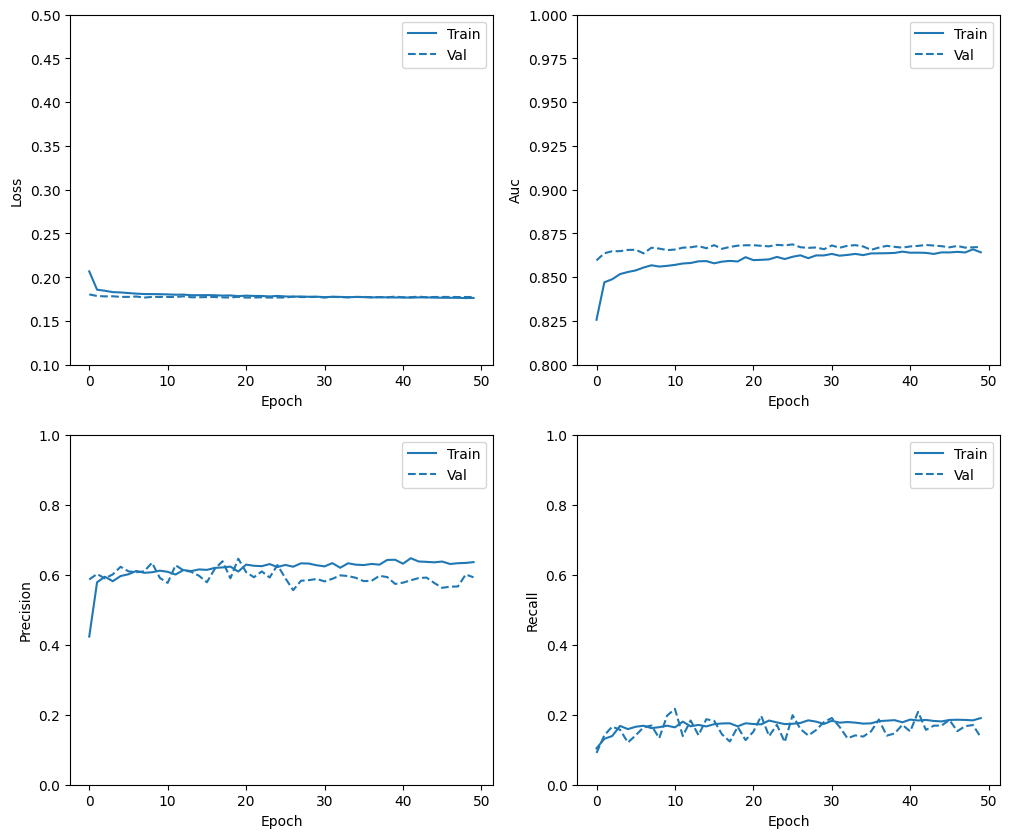

In [16]:
plot_metrics(history)

In [17]:
baseline_results = model.evaluate(X_test, y_test, batch_size=256, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)

loss :  0.17740826308727264
tp :  339.0
fp :  233.0
tn :  34765.0
fn :  2163.0
accuracy :  0.9361066818237305
precision :  0.5926573276519775
recall :  0.13549160957336426
auc :  0.8672672510147095
prc :  0.387323796749115


In [18]:
neg, pos = np.bincount(y)
total = neg + pos

In [19]:
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.54
Weight for class 1: 7.48


In [20]:
weighted_model = make_model()

weight_history = model.fit(X_train, y_train,
                    epochs=50, batch_size=256, verbose=1,
                    validation_data=(X_test, y_test),
                    class_weight=class_weight)

Epoch 1/50
440/440 [==============================] - 4s 7ms/step - loss: 0.4841 - tp: 5530.0000 - fp: 19357.0000 - tn: 85618.0000 - fn: 1994.0000 - accuracy: 0.8102 - precision: 0.2222 - recall: 0.7350 - auc: 0.8511 - prc: 0.3639 - val_loss: 0.4531 - val_tp: 1917.0000 - val_fp: 6788.0000 - val_tn: 28210.0000 - val_fn: 585.0000 - val_accuracy: 0.8034 - val_precision: 0.2202 - val_recall: 0.7662 - val_auc: 0.8659 - val_prc: 0.3859
Epoch 2/50
440/440 [==============================] - 3s 6ms/step - loss: 0.4689 - tp: 5756.0000 - fp: 20420.0000 - tn: 84555.0000 - fn: 1768.0000 - accuracy: 0.8028 - precision: 0.2199 - recall: 0.7650 - auc: 0.8603 - prc: 0.3789 - val_loss: 0.4358 - val_tp: 1890.0000 - val_fp: 6396.0000 - val_tn: 28602.0000 - val_fn: 612.0000 - val_accuracy: 0.8131 - val_precision: 0.2281 - val_recall: 0.7554 - val_auc: 0.8664 - val_prc: 0.3863
Epoch 3/50
440/440 [==============================] - 4s 10ms/step - loss: 0.4643 - tp: 5746.0000 - fp: 20323.0000 - tn: 84652.0000 

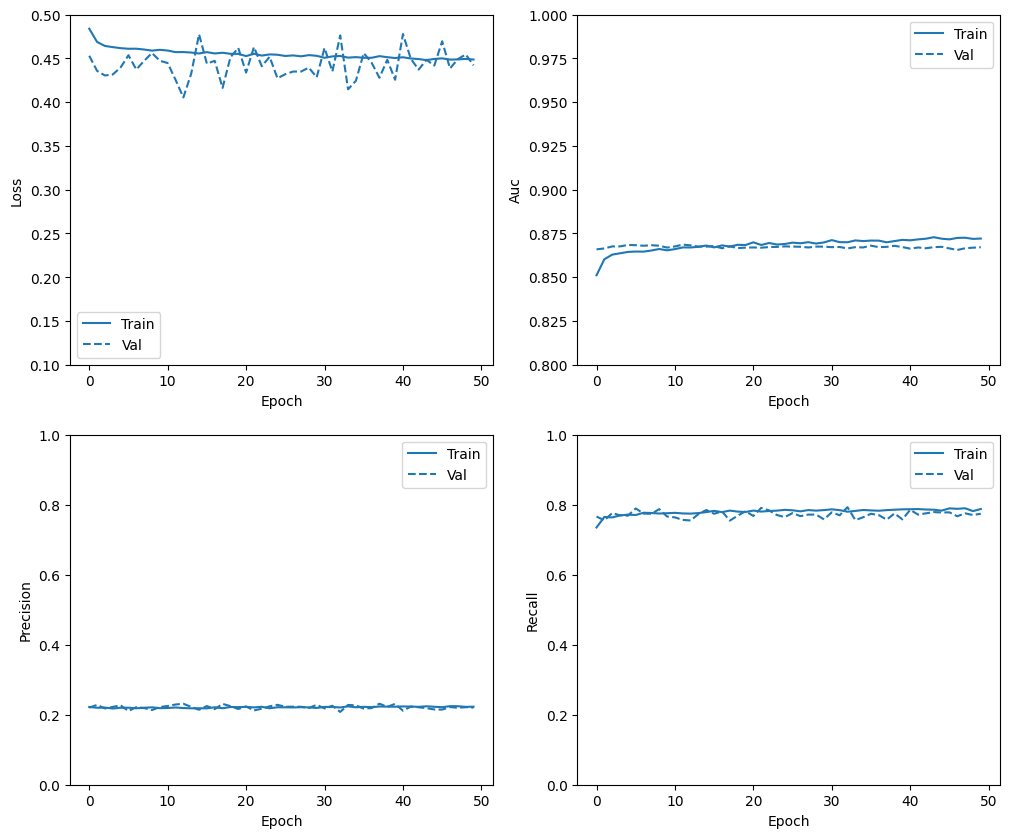

In [21]:
plot_metrics(weight_history)

In [22]:
weight_results = model.evaluate(X_test, y_test, batch_size=256, verbose=0)
for name, value in zip(model.metrics_names, weight_results):
  print(name, ': ', value)

loss :  0.4422331750392914
tp :  1937.0
fp :  6855.0
tn :  28143.0
fn :  565.0
accuracy :  0.802133321762085
precision :  0.2203139215707779
recall :  0.7741806507110596
auc :  0.8671329617500305
prc :  0.3893035650253296
